# Up Down Market Analysis
- This is a simplifed tool meant for a simple over/under market (will a player perform more or higher of some stat from a previous game)
- Finds highest EV configuration of certain stats (each stat is seperated into a different parlay)
- Useful when there are promos for risk-free 1->2 pick parlay

In [327]:
import nflreadpy as nfl

In [328]:
data = nfl.load_player_stats(True,"week")

In [329]:
data.columns

['player_id',
 'player_name',
 'player_display_name',
 'position',
 'position_group',
 'headshot_url',
 'season',
 'week',
 'season_type',
 'team',
 'opponent_team',
 'completions',
 'attempts',
 'passing_yards',
 'passing_tds',
 'passing_interceptions',
 'sacks_suffered',
 'sack_yards_lost',
 'sack_fumbles',
 'sack_fumbles_lost',
 'passing_air_yards',
 'passing_yards_after_catch',
 'passing_first_downs',
 'passing_epa',
 'passing_cpoe',
 'passing_2pt_conversions',
 'pacr',
 'carries',
 'rushing_yards',
 'rushing_tds',
 'rushing_fumbles',
 'rushing_fumbles_lost',
 'rushing_first_downs',
 'rushing_epa',
 'rushing_2pt_conversions',
 'receptions',
 'targets',
 'receiving_yards',
 'receiving_tds',
 'receiving_fumbles',
 'receiving_fumbles_lost',
 'receiving_air_yards',
 'receiving_yards_after_catch',
 'receiving_first_downs',
 'receiving_epa',
 'receiving_2pt_conversions',
 'racr',
 'target_share',
 'air_yards_share',
 'wopr',
 'special_teams_tds',
 'def_tackles_solo',
 'def_tackles_with_a

In [330]:
import polars as pl

PLAYER_NAME = "J.Flacco"
VARS = ["passing_yards","rushing_yards","passing_tds"]

var_data = []
for var in VARS:
    var_data.append(data.filter(pl.col("player_name")==PLAYER_NAME)[var])

data_info = data.filter(pl.col("player_name")==PLAYER_NAME)["season"].cast(pl.String)+data.filter(pl.col("player_name")==PLAYER_NAME)["week"].cast(pl.String)

dict_data = {
    "data_info": data_info.cast(pl.Int32)
}

for i,var in enumerate(VARS):
    dict_data["var_"+str(i)] = var_data[i].diff()>0

collected_data = pl.DataFrame(dict_data)[1:]

In [331]:
collected_data.head()

data_info,var_0,var_1,var_2
i32,bool,bool,bool
20083,false,false,false
20084,true,true,true
20085,false,true,false
20086,true,true,false
20087,false,false,true


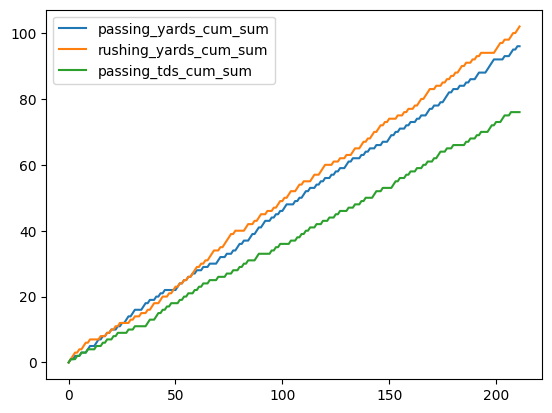

In [333]:
import matplotlib.pyplot as plt

for i,var in enumerate(VARS):
    plt.plot(collected_data["var_"+str(i)].cum_sum(),label = var+"_cum_sum")

plt.legend()


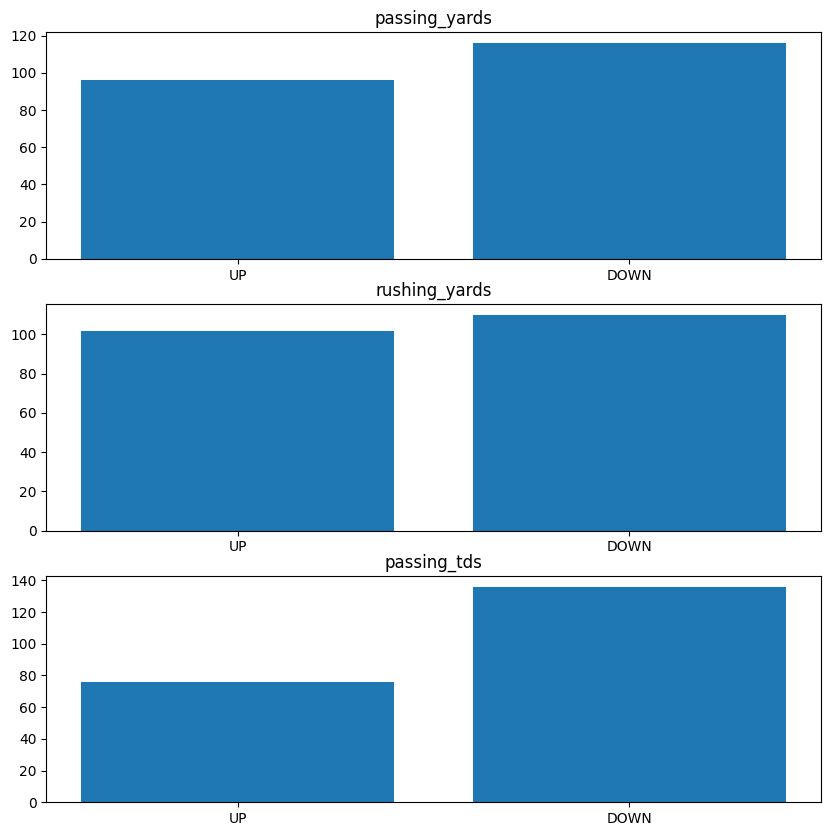

In [334]:
fig,ax = plt.subplots(len(VARS))
fig.set_size_inches(10,10)
for i,var in enumerate(VARS):
    ax[i].bar(x=["UP","DOWN"],height = (collected_data["var_"+str(i)].sum(), len(collected_data["var_"+str(i)])-collected_data["var_"+str(i)].sum()))
    ax[i].set_title(var)

In [335]:
import numpy as np

# Now get the 2^n matrix

def setup_matrix(max_len):
    all_lists = []
    def recurse_setup_matrix(list_val,max_len):
        if(len(list_val)==max_len):
            all_lists.append(np.array(list_val.copy()))
            return
        
        list_val.append(True)
        recurse_setup_matrix(list_val,max_len)

        list_val.pop()
        list_val.append(False)

        recurse_setup_matrix(list_val,max_len)

        list_val.pop()
    
    recurse_setup_matrix([],max_len)
    
    return all_lists

In [336]:
truth_matrix = setup_matrix(len(VARS))
truth_matrix

[array([ True,  True,  True]),
 array([ True,  True, False]),
 array([ True, False,  True]),
 array([ True, False, False]),
 array([False,  True,  True]),
 array([False,  True, False]),
 array([False, False,  True]),
 array([False, False, False])]

In [337]:
MULTIPLIER = 3
PAY_PER_PARLAY_CONFIG= np.array([5,5,5])
ev = []

for config_a in truth_matrix:
    total_pay = 0
    for config_b in truth_matrix:
        result_prob = 1

        for i,bool_val in enumerate(config_b):
            # If its false than bool_val (whether or not it was succesful) is flipped because we are taking the over
            result_prob*=(collected_data["var_"+str(i)] ^ (not ((not config_a[i]) ^ bool_val))).sum()/len(collected_data["var_"+str(i)])
        
        total_pay += (sum(MULTIPLIER*PAY_PER_PARLAY_CONFIG*config_b) - sum(PAY_PER_PARLAY_CONFIG))*result_prob
    
    ev.append(total_pay)

In [338]:
print(ev)

[np.float64(4.386792452830189), np.float64(8.632075471698114), np.float64(4.952830188679245), np.float64(9.19811320754717), np.float64(5.801886792452829), np.float64(10.047169811320755), np.float64(6.367924528301885), np.float64(10.613207547169813)]


In [339]:
print("EV MAX: "+str(max(ev)))

EV MAX: 10.613207547169813


In [340]:
print("OVER UNDER CONFIG: "+str(truth_matrix[ev.index(max(ev))]))

OVER UNDER CONFIG: [False False False]
